In [77]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils, probeReadWrite
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler
import plotly.express as px
import plotly

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

In [78]:
hm = 6
window_dim = hm/2/4
velTenMeters = 4

velocity_scaling = 1/velTenMeters
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [79]:
qoisOutputed = ["mass_flux", "comp(u,0)"]
qois= ["mass_flux"]

In [80]:
runs = {
    15: {'B': False, 'A': 0,  'WS': 4},
    16: {'B': False, 'A': 45, 'WS': 4},
    17: {'B': False, 'A': 0,  'WS': 2},
    21: {'B': True,  'A': 0,  'WS': 4},
    22: {'B': False, 'A': 45, 'WS': 2},
    23: {'B': True,  'A': 0,  'WS': 2},
    24: {'B': True,  'A': 45, 'WS': 2},
    25: {'B': True,  'A': 45, 'WS': 4},
}


In [81]:
start = 40000
stop = -1
by = 1

In [82]:
roomQois = ["mean", "net"]

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}


In [83]:
allFlowStats = {}
allRoomVentilation = {}
overwrite = False
for i, run in enumerate(runs):
    probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
    print(probes_dir)
    flowStatsPath = f"{probes_dir}/../flowStats.csv"
    roomVentilationPath = f"{probes_dir}/../roomVentiation.csv"
    if os.path.exists(roomVentilationPath) and os.path.exists(flowStatsPath) and overwrite == False:
        roomVentilation = pd.read_csv(roomVentilationPath, index_col=0)
        flowStats = pd.read_csv(flowStatsPath, index_col=0)
    else:
        probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")
        plt.plot(probes.probe_steps, probes.probe_times)

        ## X Flow

        @utils.no_kwargs
        def norm_norm_blocks(data_dict):
            if category == "config2":
                return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)
            return data_dict

        ## mean statistics
        x_mean = probes.statistics(
            names = [name for name in  probes.probe_names if "xwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_average, norm_norm_blocks],
            parrallel=False
            )

        ## rms statistics
        x_rms = probes.statistics(
            names = [name for name in  probes.probe_names if "xwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_rms],
            parrallel=False
            )

        ## Net flow
        x_net = probes.statistics(
            names = [name for name in  probes.probe_names if "xwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, abs_values, probePost.time_average],
            parrallel=False
            )

        x_flowStats = pd.concat([x_mean, x_rms, x_net], axis = "index").T
        x_flowStats.columns = ["mean", "rms", "net"]

        ## Z Flow

        @utils.no_kwargs
        def norm_norm_windows(data_dict):
            return probePost.mul_names(data_dict, [name for name in probes.probe_names if fnmatch(name, "*window_?-1*")], -1)

        @utils.no_kwargs
        def norm_norm_blocks(data_dict):
            if category == "config2":
                return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bx" in name], -1)
            return data_dict

        ## mean statistics
        z_mean = probes.statistics(
            names = [name for name in  probes.probe_names if "zwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_average, norm_norm_windows, norm_norm_blocks],
            parrallel=False
            )

        ## rms statistics
        z_rms = probes.statistics(
            names = [name for name in  probes.probe_names if "zwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_rms],
            parrallel=False
            )

        ## Net flow
        z_net = probes.statistics(
            names = [name for name in  probes.probe_names if "zwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, abs_values, probePost.time_average],
            parrallel=False
            )

        z_flowStats = pd.concat([z_mean, z_rms, z_net], axis = "index").T
        z_flowStats.columns = ["mean", "rms", "net"]
        ## Y Flow

        ## mean statistics
        y_mean = probes.statistics(
            names = [name for name in  probes.probe_names if "skylight" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_average, flip_data],
            parrallel=False
            )

        ## rms statistics
        y_rms = probes.statistics(
            names = [name for name in  probes.probe_names if "skylight" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_rms],
            parrallel=False
            )

        ## Net flow
        y_net = probes.statistics(
            names = [name for name in  probes.probe_names if "skylight" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, abs_values, probePost.time_average],
            parrallel=False
            )

        y_flowStats = pd.concat([y_mean, y_rms, y_net], axis = "index").T
        y_flowStats.columns = ["mean", "rms", "net"]
        ## All Flow
        flowStats = pd.concat([x_flowStats, y_flowStats, z_flowStats], axis = "index")
        flowStats = probePost.addWindowDetails(flowStats, probes.get_avg_locations(), probes.areas)

        sort_order = ["blockType", "houseType", "roomType"]
        roomVentilation = probePost.roomStatistics(flowStats, connectedWindows, roomQois)
        roomVentilation = roomVentilation.sort_values(by = sort_order)
        sort_order.append("windowType")
        flowStats = flowStats.sort_values(by = sort_order)
        display(roomVentilation)
        flowStats
        
        flowStats.to_csv(flowStatsPath)
        roomVentilation.to_csv(roomVentilationPath)
        probes = None
    allFlowStats[run] = flowStats
    allRoomVentilation[run] = roomVentilation


/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R15/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R16/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R17/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R21/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R22/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R23/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R24/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R25/probes/probesOut


In [84]:
flowStatsMI = pd.concat(allFlowStats.values(), keys=allFlowStats.keys())
roomVentilationMI = pd.concat(allRoomVentilation.values(), keys=allRoomVentilation.keys())

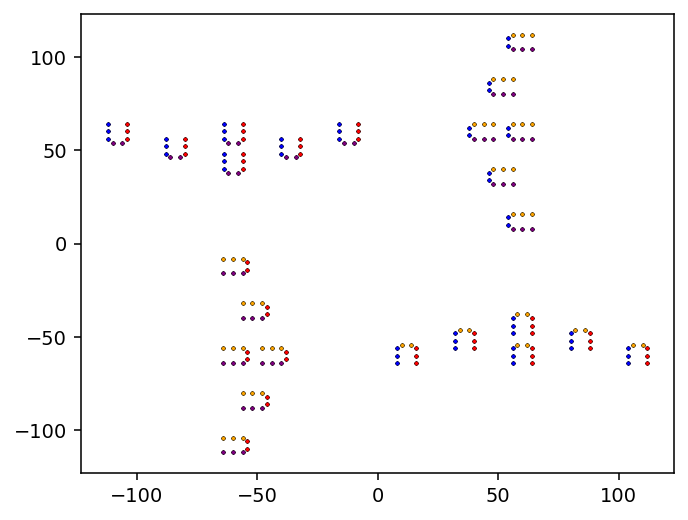

In [85]:
flowStatsMI["orientation"] = pd.Series(dtype=float)

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType.isna()) | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bxz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bz"))
    ), "orientation"] = 0

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType.isna()) | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bxz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bz"))
    ), "orientation"] = 180

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bz"))
    ) | (                                                                             
        (flowStatsMI.openingType == "zwindow") & (                                    
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bxz") |
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]')))& (flowStatsMI.blockType.isna()))
    ), "orientation"] = 90

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bxz") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType.isna()))
    ), "orientation"] = 270
    
fig, ax=plt.subplots(1, 1, constrained_layout =True)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] ==   0]['x'], flowStatsMI[flowStatsMI["orientation"] ==   0]['z'], s=4*im_scaling, c="red", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] ==  90]['x'], flowStatsMI[flowStatsMI["orientation"] ==  90]['z'], s=4*im_scaling, c="orange", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] == 180]['x'], flowStatsMI[flowStatsMI["orientation"] == 180]['z'], s=4*im_scaling, c="blue", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] == 270]['x'], flowStatsMI[flowStatsMI["orientation"] == 270]['z'], s=4*im_scaling, c="purple", edgecolors="black", linewidths=.1)
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

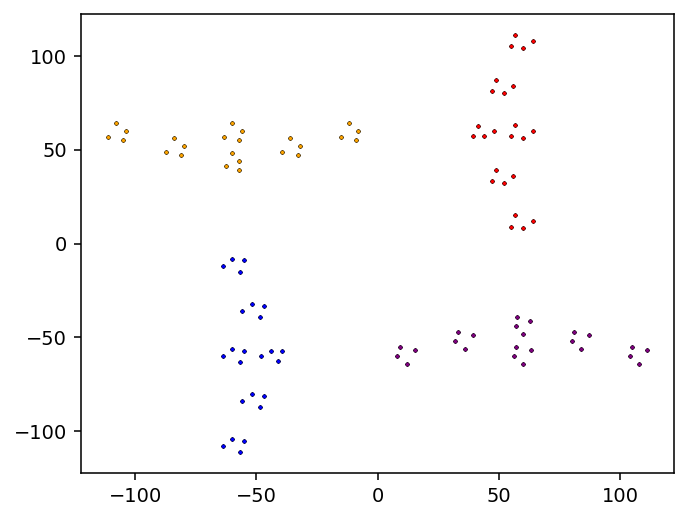

In [86]:

roomVentilationMI["orientation"] = pd.Series(dtype=float)

roomVentilationMI.loc[roomVentilationMI.blockType.isna(), "orientation"] = 0
roomVentilationMI.loc[roomVentilationMI.blockType == "Bx", "orientation"] = 90
roomVentilationMI.loc[roomVentilationMI.blockType == "Bxz", "orientation"] =180
roomVentilationMI.loc[roomVentilationMI.blockType == "Bz", "orientation"] = 270

fig, ax=plt.subplots(1, 1, constrained_layout =True)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] ==   0]['x'], roomVentilationMI[roomVentilationMI["orientation"] ==   0]['z'], s=4*im_scaling, c="red", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] ==  90]['x'], roomVentilationMI[roomVentilationMI["orientation"] ==  90]['z'], s=4*im_scaling, c="orange", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] == 180]['x'], roomVentilationMI[roomVentilationMI["orientation"] == 180]['z'], s=4*im_scaling, c="blue", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] == 270]['x'], roomVentilationMI[roomVentilationMI["orientation"] == 270]['z'], s=4*im_scaling, c="purple", edgecolors="black", linewidths=.1)
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

In [87]:
def fillInParams(df):
    AofA = pd.Series(index = df.index, dtype = float)
    WS = pd.Series(index = df.index, dtype = float)
    Buoyancy = pd.Series(index = df.index, dtype = bool)
    Params = pd.Series(index = df.index, dtype = str)
    for index, row in df.iterrows():
        run = index[0]
        angle = runs[run]["A"]
        AofA[index] = row["orientation"] + angle
        WS[index] = runs[run]["WS"]
        Buoyancy[index] = runs[run]["B"]
        if Buoyancy[index]:
            Params[index] = f"Wind Speed: {WS[index]} m/s; Buoyancy"
        else:
            Params[index] = f"Wind Speed: {WS[index]} m/s"
    df["AofA"] = AofA
    df["AofA_str"] = AofA.apply(lambda i: str(i))
    df["AofA_resid"] = AofA.apply(lambda i: str(i%90))
    df["WS"] = WS
    df["B"] = Buoyancy
    df["Params"] = Params
    for param in ["mean", "net"]:
        df[f"{param}Norm"] = df[param] / df["WS"] * 4
        # df["f{param}NormFractional"] = df[f"{param}Norm] / 
    display(df)
    return df
flowStatsMI = fillInParams(flowStatsMI)
roomVentilationMI = fillInParams(roomVentilationMI)

mean       rms       net    windowType openingType  \
15 xwindow_0-0_h_3-0   0.003392  0.099667  0.079093   xwindow_0-0     xwindow   
   zwindow_0-0_h_3-0  -0.003565  0.098751  0.078376   zwindow_0-0     zwindow   
   zwindow_2-0_h_3-0  -0.011747  0.091053  0.073916   zwindow_2-0     zwindow   
   zwindow_2-1_h_3-0   0.011283  0.091161  0.073875   zwindow_2-1     zwindow   
   xwindow_0-1_h_3-0   0.019779  0.091878  0.074038   xwindow_0-1     xwindow   
...                         ...       ...       ...           ...         ...   
25 xwindow_0-1_sl_Bz   0.110213  0.124268  0.136726   xwindow_0-1     xwindow   
   zwindow_0-1_sl_Bz   0.268605  0.113106  0.270754   zwindow_0-1     zwindow   
   zwindow_1-1_sl_Bz   0.100681  0.118070  0.125118   zwindow_1-1     zwindow   
   skylight_1-0_sl_Bz -0.008849  0.084902  0.063784  skylight_1-0    skylight   
   zwindow_1-0_sl_Bz   0.008310  0.083969  0.062765   zwindow_1-0     zwindow   

                      windowNumber houseType blockType      area          x  \
15 xwindow_0-0_h_3-0           0-0       3-0       NaN  0.562500  54.032272   
   zwindow_0-0_h_3-0           0-0       3-0       NaN  0.562500  56.000000   
   zwindow_2-0_h_3-0           2-0       3-0       NaN  0.562500  64.000000   
   zwindow_2-1_h_3-0           2-1       3-0       NaN  0.569530  64.000274   
   xwindow_0-1_h_3-0           0-1       3-0       NaN  0.562500  54.037566   
...                            ...       ...       ...       ...        ...   
25 xwindow_0-1_sl_Bz           0-1        sl        Bz  0.564852  61.999991   
   zwindow_0-1_sl_Bz           0-1        sl        Bz  0.563764  63.925112   
   zwindow_1-1_sl_Bz           1-1        sl        Bz  0.565068  63.924364   
   skylight_1-0_sl_Bz          1-0        sl        Bz  0.577597  58.007140   
   zwindow_1-0_sl_Bz           1-0        sl        Bz  0.563229  56.071573   

                       ...  roomType  orientation   AofA  AofA_str  \
15 xwindow_0-0_h_3-0   ...    corner        180.0  180.0     180.0   
   zwindow_0-0_h_3-0   ...    corner        270.0  270.0     270.0   
   zwindow_2-0_h_3-0   ...     cross        270.0  270.0     270.0   
   zwindow_2-1_h_3-0   ...     cross         90.0   90.0      90.0   
   xwindow_0-1_h_3-0   ...      dual        180.0  180.0     180.0   
...                    ...       ...          ...    ...       ...   
25 xwindow_0-1_sl_Bz   ...      dual         90.0  135.0     135.0   
   zwindow_0-1_sl_Bz   ...      dual          0.0   45.0      45.0   
   zwindow_1-1_sl_Bz   ...      dual          0.0   45.0      45.0   
   skylight_1-0_sl_Bz  ...    single          NaN    NaN       nan   
   zwindow_1-0_sl_Bz   ...    single        180.0  225.0     225.0   

                       AofA_resid   WS      B                         Params  \
15 xwindow_0-0_h_3-0          0.0  4.0  False            Wind Speed: 4.0 m/s   
   zwindow_0-0_h_3-0          0.0  4.0  False            Wind Speed: 4.0 m/s   
   zwindow_2-0_h_3-0          0.0  4.0  False            Wind Speed: 4.0 m/s   
   zwindow_2-1_h_3-0          0.0  4.0  False            Wind Speed: 4.0 m/s   
   xwindow_0-1_h_3-0          0.0  4.0  False            Wind Speed: 4.0 m/s   
...                           ...  ...    ...                            ...   
25 xwindow_0-1_sl_Bz         45.0  4.0   True  Wind Speed: 4.0 m/s; Buoyancy   
   zwindow_0-1_sl_Bz         45.0  4.0   True  Wind Speed: 4.0 m/s; Buoyancy   
   zwindow_1-1_sl_Bz         45.0  4.0   True  Wind Speed: 4.0 m/s; Buoyancy   
   skylight_1-0_sl_Bz         nan  4.0   True  Wind Speed: 4.0 m/s; Buoyancy   
   zwindow_1-0_sl_Bz         45.0  4.0   True  Wind Speed: 4.0 m/s; Buoyancy   

                       meanNorm   netNorm  
15 xwindow_0-0_h_3-0   0.003392  0.079093  
   zwindow_0-0_h_3-0  -0.003565  0.078376  
   zwindow_2-0_h_3-0  -0.011747  0.073916  
   zwindow_2-1_h_3-0   0.011283  0.073875  
   xwindow_0-1_h_3-0   0.019779  0.074038  
...                         ...       .

mean       net  contResid houseType blockType  \
15 corner_h_3-0     0.003479  0.078734  -0.000347       3-0       NaN   
   cross_h_3-0      0.011515  0.073896  -0.000927       3-0       NaN   
   dual_h_3-0       0.042457  0.100722  -0.000106       3-0       NaN   
   single_h_3-0     0.000217  0.001234  -0.000867       3-0       NaN   
   corner_h_3-1     0.011739  0.069984   0.000062       3-1       NaN   
...                      ...       ...        ...       ...       ...   
25 single_h_3-4_Bz  0.000693  0.000983   0.001385       3-4        Bz   
   corner_sl_Bz     0.309528  0.310614  -0.006367        sl        Bz   
   cross_sl_Bz      0.638235  0.648408   0.012540        sl        Bz   
   dual_sl_Bz       0.473687  0.501157   0.011623        sl        Bz   
   single_sl_Bz     0.008579  0.063275  -0.000539        sl        Bz   

                   roomType           x         y          z  orientation  \
15 corner_h_3-0      corner   55.016136  1.500000   9.022450          0.0   
   cross_h_3-0        cross   64.000137  1.498593  11.969118          0.0   
   dual_h_3-0          dual   56.678986  1.498136  15.262142          0.0   
   single_h_3-0      single   60.000000  1.500000   8.045070          0.0   
   corner_h_3-1      corner   47.015594  1.497615  33.055550          0.0   
...                     ...         ...       ...        ...          ...   
25 single_h_3-4_Bz   single  104.023340  1.499420 -59.997758        270.0   
   corner_sl_Bz      corner   57.358756  1.966833 -39.331883        270.0   
   cross_sl_Bz        cross   59.999651  2.203340 -48.000003        270.0   
   dual_sl_Bz          dual   62.769886  2.060568 -41.199981        270.0   
   single_sl_Bz      single   57.039356  2.197882 -44.000548        270.0   

                     AofA AofA_str AofA_resid   WS      B  \
15 corner_h_3-0       0.0      0.0        0.0  4.0  False   
   cross_h_3-0        0.0      0.0        0.0  4.0  False   
   dual_h_3-0         0.0      0.0        0.0  4.0  False   
   single_h_3-0       0.0      0.0        0.0  4.0  False   
   corner_h_3-1       0.0      0.0        0.0  4.0  False   
...                   ...      ...        ...  ...    ...   
25 single_h_3-4_Bz  315.0    315.0       45.0  4.0   True   
   corner_sl_Bz     315.0    315.0       45.0  4.0   True   
   cross_sl_Bz      315.0    315.0       45.0  4.0   True   
   dual_sl_Bz       315.0    315.0       45.0  4.0   True   
   single_sl_Bz     315.0    315.0       45.0  4.0   True   

                                           Params  meanNorm   netNorm  
15 corner_h_3-0               Wind Speed: 4.0 m/s  0.003479  0.078734  
   cross_h_3-0                Wind Speed: 4.0 m/s  0.011515  0.073896  
   dual_h_3-0                 Wind Speed: 4.0 m/s  0.042457  0.100722  
   single_h_3-0               Wind Speed: 4.0 m/s  0.000217  0.001234  
   corner_h_3-1               Wind Speed: 4.0 m/s  0.011739  0.069984  
...                                           ...       ...       ...  
25 single_h_3-4_Bz  Wind Speed: 4.0 m/s; Buoyancy  0.000693  0.000983  
   corner_sl_Bz     Wind Speed: 4.0 m/s; Buoyancy  0.309528  0.310614  
   cross_sl_Bz      Wind Speed: 4.0 m/s; Buoyancy  0.638235  0.648408  
   dual_sl_Bz       Wind Speed: 4.0 m/s; Buoyancy  0.473687  0.501157  
   single_sl_Bz     Wind Speed: 4.0 m/s; Buoyancy  0.008579  0.063275  

[768 rows x 18 columns]

In [88]:
# fig, ax=plt.subplots(1, 1, constrained_layout =True)
# for houseType in set(flowStatsMI["houseType"]):
#     plotdf = flowStatsMI[flowStatsMI["AofA"] == 0]
#     plotdf = plotdf[plotdf["houseType"] == houseType]
#     ax.scatter(plotdf["meanNorm"], plotdf["roomType"], label=Params)
# # fig.legend()

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.



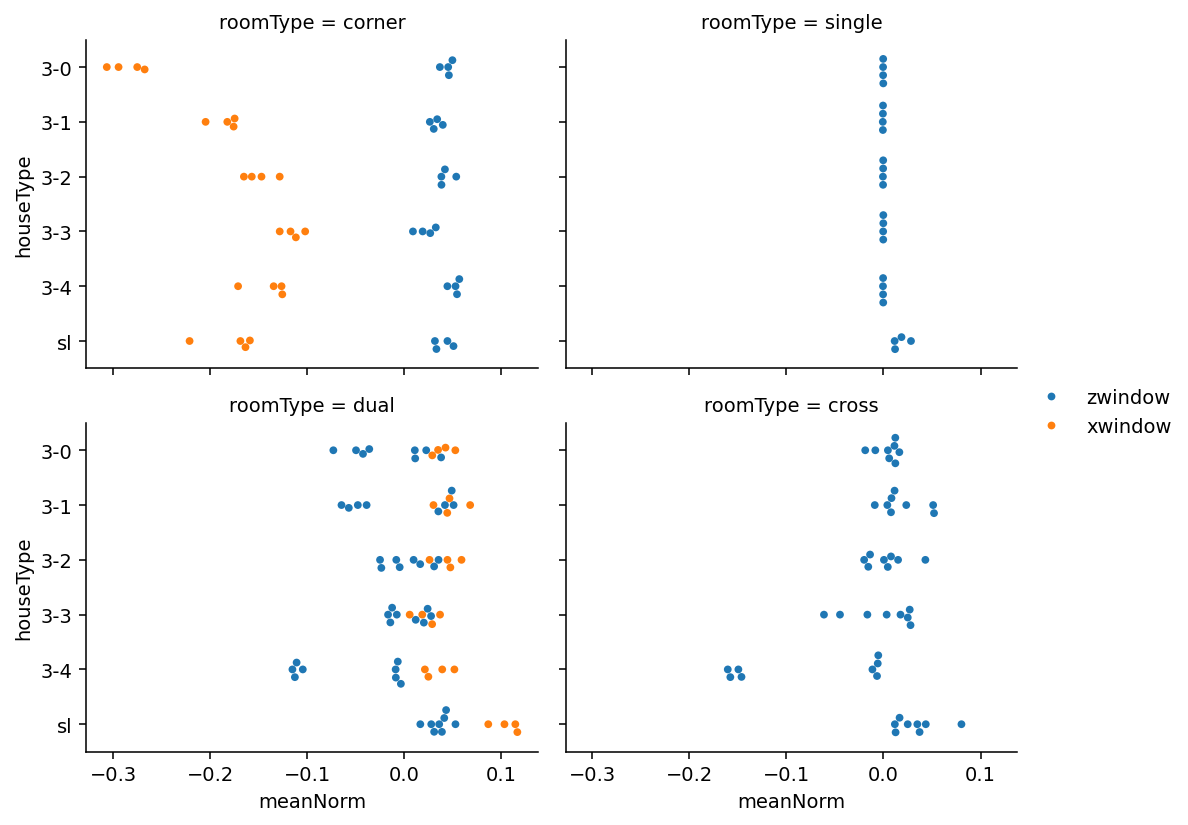

In [89]:
g = sns.FacetGrid(flowStatsMI[flowStatsMI["AofA"] == 90], col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "meanNorm", "houseType", "openingType", palette = "tab10", size = 4)
g.add_legend()

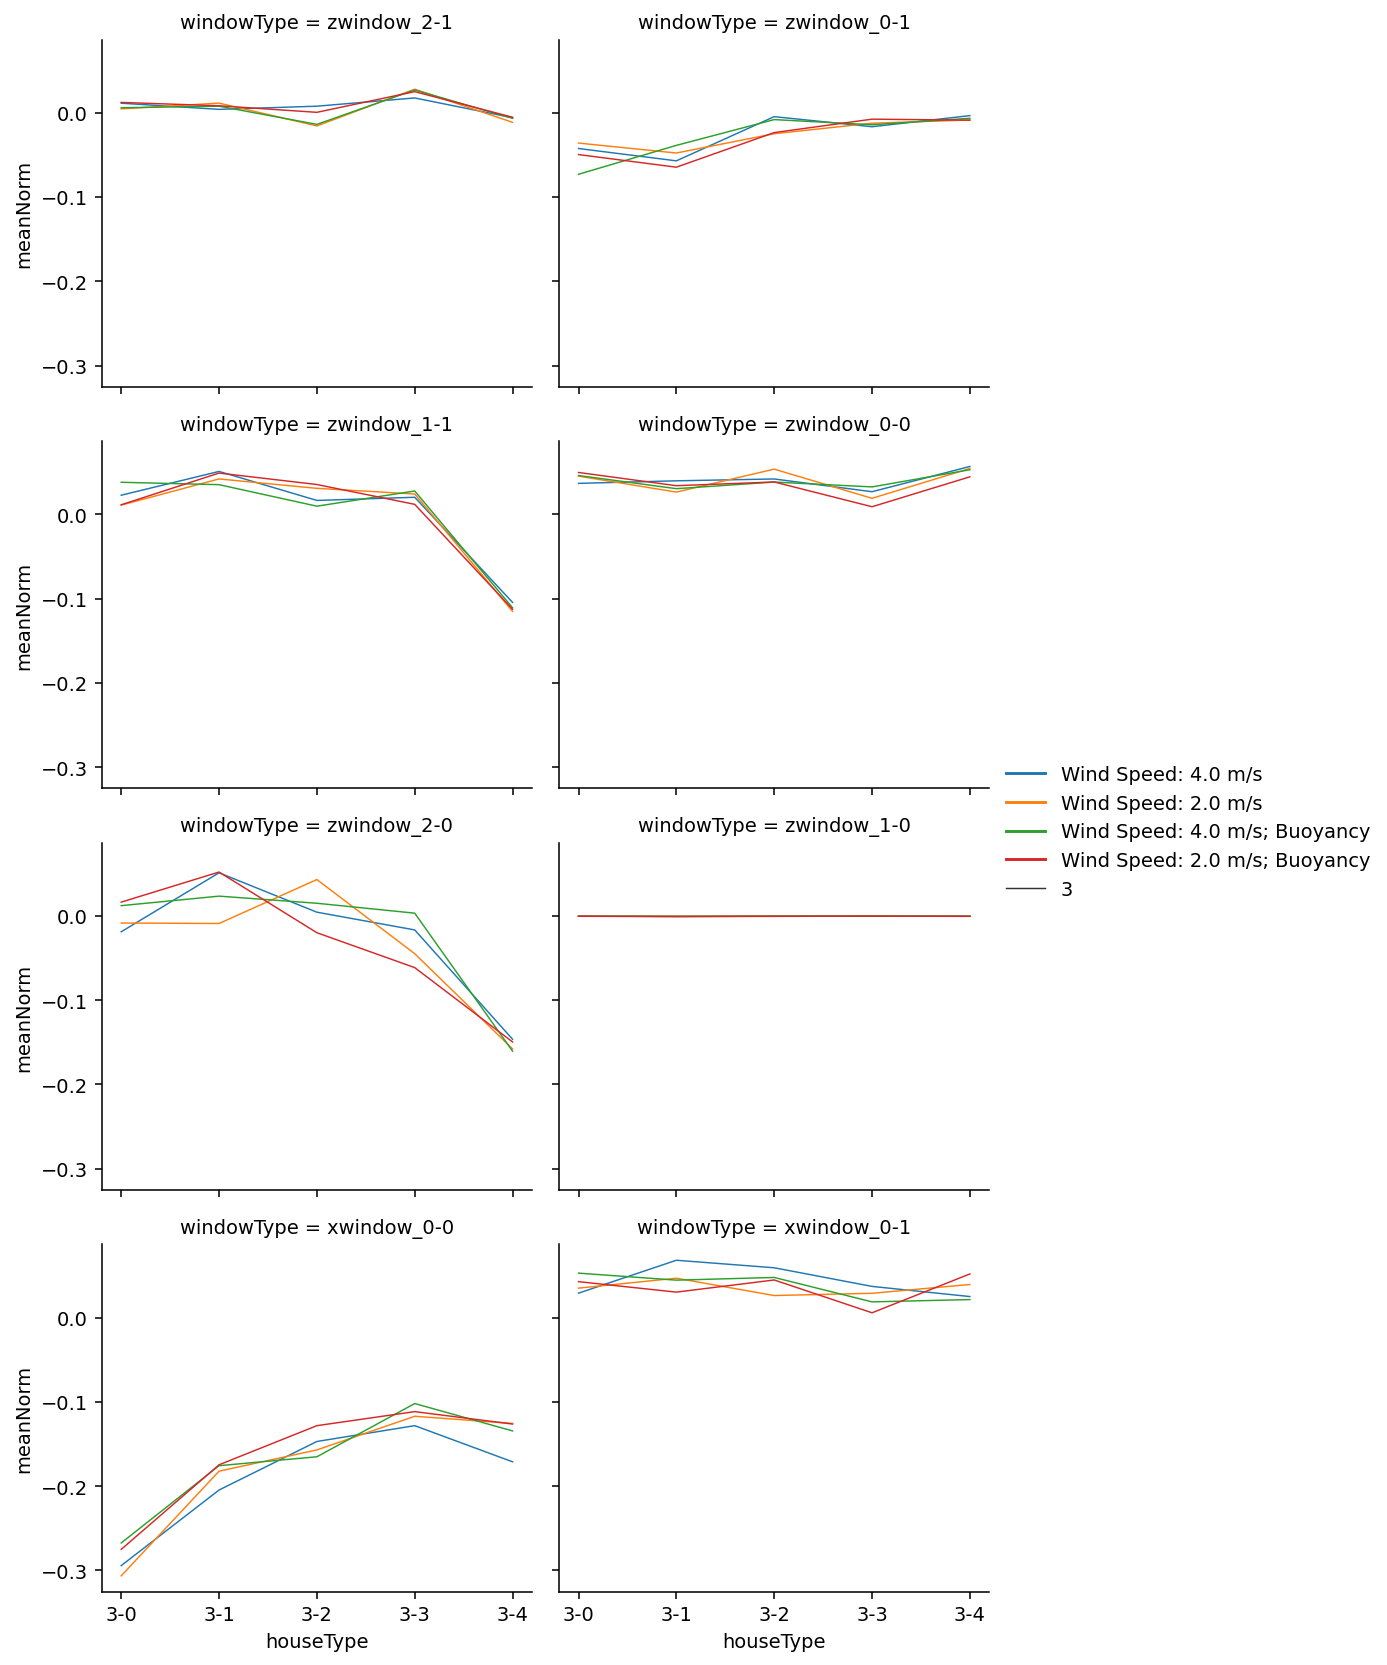

In [90]:
plotdf = flowStatsMI[flowStatsMI["AofA"] == 90]
plotdf = plotdf[plotdf["houseType"] != "sl"]
g = sns.FacetGrid(plotdf, col = "windowType", col_wrap = 2, aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.lineplot, "houseType", "meanNorm", "Params", palette = "tab10", size = 3)
g.add_legend()

/tmp/ipykernel_11103/1381535364.py:4: UserWarning:


The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.



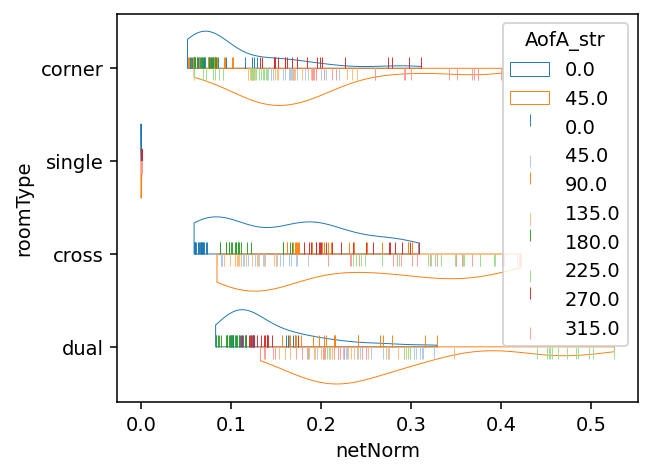

In [91]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"] != "sl"]
plotdf = plotdf.sort_values(["AofA"])
g = sns.violinplot(data=plotdf, x="netNorm", y="roomType", hue="AofA_resid", fill = False, inner = None, linewidth = .5, density_norm = "width", cut = 0, split=True)
g = sns.scatterplot(data=plotdf, x="netNorm", y="roomType", hue="AofA_str", style=plotdf["AofA_str"], palette="tab20", markers = [2,3])

In [111]:
plotdf = plotdf.sort_values(["Params"])
fig1 = px.bar_polar(plotdf, r="netNorm", theta="AofA",
                   color="roomType", template="plotly_dark", pattern_shape = "WS",
                   color_discrete_sequence= px.colors.sequential.Viridis)
fig1.show()

fig2 = px.bar_polar(plotdf, r="netNorm", theta="AofA",
                   color="roomType", template="plotly_dark", pattern_shape = "B",
                   color_discrete_sequence= px.colors.sequential.Viridis)
fig2.show()

In [112]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots

rooms = ["corner", "single", "dual", "cross"]
params = set(plotdf["Params"])
marker_color=["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4']
color_map = {}
for i, param in enumerate(params):
    color_map[i] = marker_color[i]

figures = []
for i, room in enumerate(rooms):
    fig = px.bar_polar(plotdf[plotdf["roomType"] == room], r="netNorm", theta="AofA",
                   color="Params", template="plotly_dark",
                   color_discrete_map=color_map, title=room)
    # fig.update_raxes(ticklabelposition="outside bottom", title=None)
    figures.append(fig)

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, subplot_titles=rooms, vertical_spacing=0.2)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        room = rooms[i]
        row = int((i/2)+1)
        col = int((i%2)+1)
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        fig.update_annotations(y=1.1 - (row-1)/1.5, selector={'text':room})

fig.update_polars(radialaxis_dtick=2)
# fig.update_polars(overwrite=True, radialaxis_dtick=.5, selector={'text':'single'})
fig.update_layout(width = 1000, height = 800)


fig.show()
print(type(fig))
# print(fig)

<class 'plotly.graph_objs._figure.Figure'>


In [113]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots

rooms = ["corner", "single", "dual", "cross"]
params = set(plotdf["Params"])
marker_color=["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4']
color_map = {}
for i, param in enumerate(params):
    color_map[i] = marker_color[i]

figures = []
for i, room in enumerate(rooms):
    fig = px.bar_polar(plotdf[plotdf["roomType"] == room], r="netNorm", theta="AofA",
                   color="houseType", template="plotly_dark",
                   color_discrete_map=color_map, title=room)
    # fig.update_raxes(ticklabelposition="outside bottom", title=None)
    figures.append(fig)

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, subplot_titles=rooms, vertical_spacing=0.2)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        room = rooms[i]
        row = int((i/2)+1)
        col = int((i%2)+1)
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        fig.update_annotations(y=1.1 - (row-1)/1.5, selector={'text':room})

fig.update_polars(radialaxis_dtick=2)
# fig.update_polars(overwrite=True, radialaxis_dtick=.5, selector={'text':'single'})
fig.update_layout(width = 1000, height = 800)


fig.show()
print(type(fig))

<class 'plotly.graph_objs._figure.Figure'>


In [78]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)

fig.add_trace(go.Barpolar(
      name = "angular categories",
      r = plotdf["netNorm"].values,
      theta = plotdf["AofA"].values,
      # color = plotdf["Params"].values
    ), 1, 1)
fig.add_trace(go.Barpolar(
      name = "radial categories",
      r = ["a", "b", "c", "d", "b", "f", "a"],
      theta = [1, 4, 2, 1.5, 1.5, 6, 5],
      thetaunit = "radians",
    ), 1, 2)
fig.add_trace(go.Barpolar(
      name = "angular categories (w/ categoryarray)",
      r = [5, 4, 2, 4, 5],
      theta = ["a", "b", "c", "d", "a"],
    ), 2, 1)
fig.add_trace(go.Barpolar(
      name = "radial categories (w/ category descending)",
      r = ["a", "b", "c", "d", "b", "f", "a", "a"],
      theta = [45, 90, 180, 200, 300, 15, 20, 45],
    ), 2, 2)

# fig.update_traces(fill='toself')
fig.update_layout(
    polar = dict(
      radialaxis_angle = -45,
      angularaxis = dict(
        direction = "clockwise",
        period = 6)
    ),
    polar2 = dict(
      radialaxis = dict(
        angle = 180,
        tickangle = -180 # so that tick labels are not upside down
      )
    ),
    polar3 = dict(
      sector = [80, 400],
      radialaxis_angle = -45,
      angularaxis_categoryarray = ["d", "a", "c", "b"]
    ),
    polar4 = dict(
      radialaxis_categoryorder = "category descending",
      angularaxis = dict(
        thetaunit = "radians",
        dtick = 0.3141592653589793
      ))
)

fig.show()

In [ ]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"] != "sl"]
g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.scatterplot, "meanNorm", "AofA_str", "B", style = roomVentilationMI["WS"], palette = "tab10", markers = [10, 11])
# g.map(sns.stripplot, "meanNorm", "AofA_str", "Params", palette = "tab10", size=2, dodge = True, jitter= False)
g.map(sns.violinplot, "meanNorm", "AofA_str", "Params", fill = False, inner = "stick", linewidth = .5, density_norm = "width", cut = 0, split=True)

# g.map(sns.rugplot, "meanNorm", "AofA", "B")
g.add_legend()

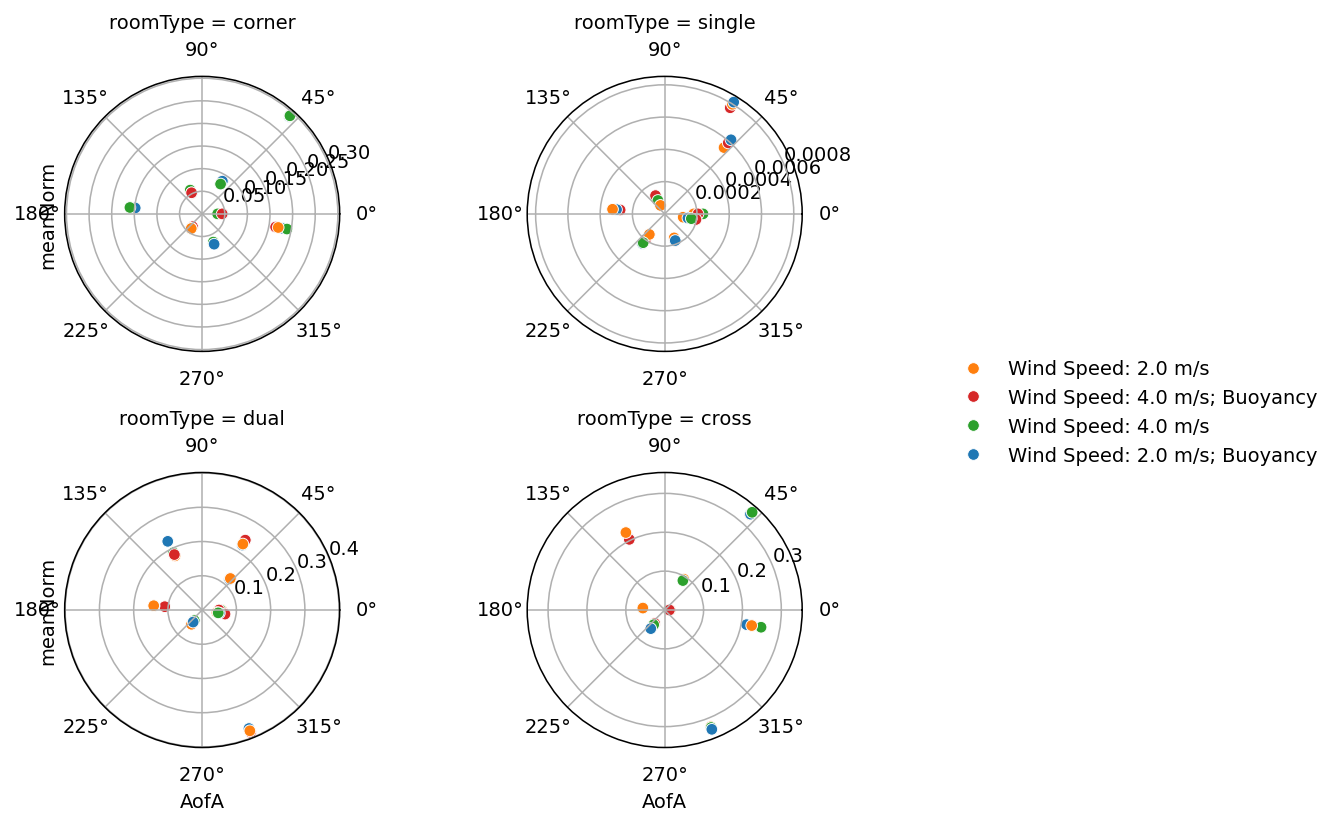

In [141]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"] != "sl"]
plotdf = plotdf[["roomType", "Params", "AofA", "meanNorm"]]
plotdf = plotdf.groupby(["roomType", "Params", "AofA"], as_index=False).mean()
plotdf = plotdf.sort_values(["AofA"])

# g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, subplot_kws=dict(projection='polar'), col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True, 
sharex=False, sharey=False, despine=False)
g.map(sns.scatterplot, "AofA", "meanNorm", "Params") 
g.add_legend()

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm=colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"]/flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsOnetInterior', bbox_inches="tight")

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["contResid"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/residRooms', bbox_inches="tight")

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowsRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowsRooms', bbox_inches="tight")

In [ ]:
dfWindows = flowStats.loc[flowStats["openingType"].isin(["xwindow", "zwindow"])]

sns.lmplot(data = dfWindows, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/windowKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "windowType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowViolins', bbox_inches="tight")

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowViolins', bbox_inches="tight")

In [ ]:
sns.lmplot(data = roomVentilation, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/roomKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRoomViolins', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRoomViolins', bbox_inches="tight")

In [ ]:
g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "net", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netHouseByRoom', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "mean", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanHouseByRoom', bbox_inches="tight")

## Convergence

In [ ]:
data = probes.statistics(
    names = [name for name in probes.probe_names if "door" not in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [],
    parrallel=False
    )

In [ ]:
xPlot = data.index.values
yPlot = np.arange(len(data.keys()))

fig, ax=plt.subplots(1, 1, constrained_layout = True)
im=ax.scatter(flowStats.loc[data.keys(), 'x'], flowStats.loc[data.keys(), 'z'], s=4, c=yPlot, cmap='tab20c', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/dataMap', bbox_inches="tight")

In [ ]:
dataCumMean = probePost.cumulative_mean(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataCumMean.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)
# ax.set_yticks(yPlot)
# ax.set_yticklabels(dataCumMean.keys())

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourCumMean', bbox_inches="tight")

In [ ]:
dataConv = probePost.convergence(dataCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataConv.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourConv', bbox_inches="tight")

In [ ]:
dataRevCumMean = probePost.reverse(data)
dataRevCumMean = probePost.cumulative_mean(dataRevCumMean)
dataRevCumMean = probePost.reverse(dataRevCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataRevCumMean.abs().T, cmap = "inferno", levels=40, vmax = 1)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourRevCumMean', bbox_inches="tight")

In [ ]:
@utils.no_kwargs
@utils.dict_apply
def sma(df): 
    return df.rolling(8000).mean()
    
dataSMA = sma(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataSMA.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourSMA', bbox_inches="tight")